# Duplicate Question Pairs Detection

__In this notebook, we implement our solution to "Duplicate Question Pairs Detection" with classifiers using hand-crafted features.__

_This notebook is divided as follows_:
> 1. Data Loading
> 2. Feature Extraction
> 3. Model Fitting
> 4. Evaluation of our Models

##### Import Statements

In [1]:
import sys
from __future__ import unicode_literals
import pandas as pd
import pyemd as emd
import numpy as np
import os
from gensim.models import KeyedVectors
import gensim
from nltk.tokenize import word_tokenize
from scipy import spatial
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from nltk.corpus import wordnet as wn
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import spacy
from xgboost import XGBClassifier
from sklearn import svm
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import networkx as nx
import pickle
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
import pickle
import lightgbm as lgb
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import itertools

/home/shared/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


##### Create Instances of PorterStemmer, Spacy, SentimentIntensityAnalyzer
##### Create set of stop words

In [2]:
ps = PorterStemmer()
nlp = spacy.load('en')
analyzer = SentimentIntensityAnalyzer()
stop = set(stopwords.words('english'))

## 1. Data Loading

##### Load Train and Test Data

In [2]:
df_test = pd.read_csv('data/test.csv', encoding="utf-8").fillna("")
df_train = pd.read_csv('data/train.csv', encoding="utf-8").fillna("")

##### Load Word2Vec Model

In [3]:
w2v_model = KeyedVectors.load_word2vec_format('google_news_word_vectors/GoogleNews-vectors-negative300.bin', binary = True)

__On inspecting the training and testing data, we observed that there is a qid associated with the questions in training data but they are not present in the testing data. Hence in this section we create a custom mapping of all train and test data to ID values__

In [5]:
question_map = dict()

##### Map Training Data

In [6]:
for index, row in df_train.iterrows():
    
    question_id_1 = row["qid1"]
    question_id_2 = row["qid2"]
    
    q1 = row['question1'].strip(' ')
    q2 = row['question2'].strip(' ')
    
    if q1 not in question_map:
        question_map[q1] = question_id_1
        
    if q2 not in question_map:
        question_map[q2] = question_id_2
        

##### Map Testing Data

In [ ]:
count = max(question_map.values())

for index, row in df_test.iterrows():
    
    q1 = row['question1'].strip(' ')
    q2 = row['question2'].strip(' ')
    
    
    if q1 not in question_map:
        question_map[q1] = count + 1
        count = count + 1
        
    if q2 not in question_map:
        question_map[q2] = count + 1
        count = count + 1
        
    if(index%500000 == 0):
        print(index)
        print(len(question_map))
        print('\n')

## 2. Feature Extraction

__In this section, we extract the features for our dataset.__

For our dataset, we extract three kinds of features:
> 1. Graph Based Features
> 2. Language Based Features
> 3. Similarity Based Features


##### 1. Graph Based Features

We extract the following graph based features from our data:
> PageRank Scores of the Questions <br>
> Common Neighbors of the Questions <br>
> Degree of the Questions <br>

#####  To represent our dataset as a graph, we create an adjecency list of all our questions as shown in the following code. <br>
##### Degree of a node can be easily computed by computing the length of the adjacency list for any node

In [8]:
#questions_map contains the mapping from question to its index in the train and test combined

qid_graph = {}

Data = [df_train, df_test]
    
for data in Data:
    
    for index, row in data.iterrows():
        
        q1 = row['question1'].strip(' ')
        q2 = row['question2'].strip(' ')
        
        question_id_1 = question_map.get(q1)
        question_id_2 = question_map.get(q2)

        qid_graph.setdefault(question_id_1, []).append(question_id_2)
        qid_graph.setdefault(question_id_2, []).append(question_id_1)
     
    print('done')

done
done


In [9]:
def pagerank(qid_graph):

    MAX_ITER = 20 
    d = 0.85
    
    #Initializing -- every node gets a uniform value!
    pagerank_dict = {i:1/len(qid_graph) for i in qid_graph}
    num_nodes = len(pagerank_dict)
    
    for iter in range(0, MAX_ITER):
        
        for node in qid_graph:    
            local_pr = 0
            
            for neighbor in qid_graph[node]:
                local_pr += pagerank_dict[neighbor]/len(qid_graph[neighbor])
            
            pagerank_dict[node] = (1-d)/num_nodes + d*local_pr

    return pagerank_dict

pagerank_dict = pagerank(qid_graph)

In [2]:
def common_neighbours(id1,id2):
    
    try:
        list1 = qid_graph[id1]
        list2 = qid_graph[id2]
    except:
        return 0
    
    return len(list(set(list1).intersection(list2)))

##### 2. Language Based Features

We extract the following language based features from our dataset:

> 1. Word2vec embedding representation of sentence
> 2. Dot product of Tfidf vectors of question pair
> 3. Common entities in question pairs
> 4. Common nouns in question pairs
> 5. Jaccard similarity between embeddigs of question pair
> 6. Canberra similarity between embeddigs of question pair
> 7. Cityblock similarity between embeddigs of question pair
> 8. Eucledian similarity between embeddigs of question pair
> 9. Cosine similarity between embeddigs of question pair
> 10. Minkowski similarity between embeddigs of question pair
> 11. Braycurtis similarity between embeddigs of question pair
> 12. Wordmover distance between embeddings
> 13. Skew and kurtosis
> 14. Sentiment of questions
> 15. Common number of bigrams
> 16. Fuzz ratio, partial ratio, token sort ratio of question pairs
> 17. Type of question

In [14]:
#Average Word2vec title
def vector_title(sentence, w2v_model):
    
    sentence = word_tokenize(sentence)
    sentence_new = []
    
    #Apply stemming
    for word in sentence:
        sentence_new.append(ps.stem(word))  
    sentence = sentence_new 
    
    if (len(sentence) == 0) or (type(sentence) == float):
        return "Error"
    
    vec = np.zeros(300)
    for w in sentence:
        try:
            vec += w2v_model[w]
        except:
            pass

    return vec/len(sentence)


def tfidf(d1, d2):
    intersect = set(d1).intersection(set(d2))
    if len(intersect) == 0:
        return 0.0

    tid = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, 
            smooth_idf=False, sublinear_tf=True, tokenizer=tokenize)
    try:
        represent = tid.fit_transform([d1, d2]).toarray()
    except ValueError:
        return 0.0
    
    
    # Taking dot product
    product = 0
    sum1 = 0
    sum2 = 0
    for i in range(len(represent[0])):
        product += represent[0][i] * represent[1][i]
        sum1 += pow(represent[0][i], 2)
        sum2 += pow(represent[1][i], 2)

    denom = math.sqrt(sum1 * sum2)
    if int(denom) == 0:
        return 0.0

    return float(product)/denom



def tokenize(d):
    clean = re.sub(r'[^\w]', ' ', d)
    tk = clean.lower().split()
    return [word for word in tk if word not in stop]


#Statistics to measure the common entities in both the sentence.
def common_ne_score(q1,q2):

    q1 = nlp(q1)
    q2 = nlp(q2)

    q1_ne = q1.ents
    q2_ne = q2.ents

    q1_ne = set([str(i) for i in q1_ne])
    q2_ne = set([str(i) for i in q2_ne])

    common_ne = len(q1_ne.intersection(q2_ne))

    if len(q1_ne) + len(q2_ne) == 0:
        return 0
    
    return common_ne/(float)(len(q1_ne) + len(q2_ne) - common_ne)



#Statistics to measure the common nouns in both the sentence.
def common_chunk_score(q1,q2):

    q1 = nlp(q1)
    q2 = nlp(q2)

    q1_nc = q1.noun_chunks
    q2_nc = q2.noun_chunks

    q1_nc = set([str(i) for i in q1_nc])
    q2_nc = set([str(i) for i in q2_nc])

    common_nc = len(q1_nc.intersection(q2_nc))

    if len(q1_nc) + len(q2_nc) == 0:
        return 0
    
    return common_nc/(float)(len(q1_nc) + len(q2_nc) - common_nc)


def common_bigrams(q1, q2):
    text = [q1]
    q1_bigrams = [b for l in text for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
    
    text = [q2]
    q2_bigrams = [b for l in text for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
    
    #print(q1_bigrams)
    #print(q2_bigrams)

    count = 0
    for pair in q1_bigrams:
        if pair in q2_bigrams:
            count = count + 1
    
    return count
    

In [66]:
def extract_features(df, w2v_model, nolabels=False):
    
    features = []
    labels = []
    for index, row in df.iterrows():
            
        q1 = row['question1']
        q2 = row['question2']
        
        q1_index = question_map.get(q1)
        q2_index = question_map.get(q2)      
        
        if q1 == "" or q2 == "":
            current_feature = [0]*2
            features.append(current_feature)            
            continue
        
        if not nolabels:
            label = row['is_duplicate']
        else:
            label = None
        
        if type(q1) == float or type(q2) == float:
            current_feature = [0]*2
            features.append(current_feature)            
            continue

        q1 = re.sub(r'[^\w]', ' ', q1)
        q2 = re.sub(r'[^\w]', ' ', q2)

        q1 = q1.lower()
        q2 = q2.lower()
        
        
        current_feature = []

        q1_afv = vector_title(q1, w2v_model)
        q2_afv = vector_title(q2, w2v_model)
        
        if q1_afv == "Error" or q2_afv == "Error":
            
            print('Error')
            print(index)
            current_feature = [0]*30
            features.append(current_feature)
            continue
        
        #Jaccard Similarity
        qjac_sim = jaccard(q1_afv,q2_afv)     
        
        #Canberra Similarity
        qcan_sim = canberra(q1_afv,q2_afv)       

        #CityBlock Similarity
        qcity_sim = cityblock(q1_afv,q2_afv)        
  
        #Eucledian Similarity
        qeuc_sim = euclidean(q1_afv,q2_afv)

        #Cosine Similarity
        qcos_sim = cosine(q1_afv, q2_afv)    
        
        #Minowski Similarity
        qmin_sim = minkowski(q1_afv, q2_afv)    
        
        #braycurtis Similarity
        qbay_sim = braycurtis(q1_afv, q2_afv)    
        
        #WordMover's distance
        mover_distance = w2v_model.wmdistance(q1, q2)
        
        
        #Fuzzy Features
        fuzz_ratio = fuzz.ratio(q1,q2)
        fuzz_partialratio = fuzz.partial_ratio(q1,q2) 
        fuzz_tokenratio = fuzz.token_sort_ratio(q1,q2) 
        
        #Skew and Kurtosis
        q1_skew = skew(q1_afv)
        q2_skew = skew(q2_afv)
        q1_kurtosis = kurtosis(q1_afv)
        q2_kurtosis = kurtosis(q2_afv)
        
        #Common number of bigrams
        common_bigrams_count = common_bigrams(q1,q2)
        
        #Common NE Score
        q_ne_score = common_ne_score(q1,q2)
        
        #Common Noun Score
        q_noun_score = common_chunk_score(q1,q2)
        
        #TF-IDF
        q_tfidf = tfidf(q1, q2)
        
        #Get the sentiment
        q1_sentiment = analyzer.polarity_scores(q1)
        q2_sentiment = analyzer.polarity_scores(q2)
        #ratio = float(q1_sentiment['compound'])/q2_sentiment['compound']
        
        
        #Features to check for (what,which,does,when,Can,Who,Will,Did) and (why, how)
        if 'why' in q1.lower() or 'how' in q1.lower():
            q1_question_type = 1
        else:
            q1_question_type = 0
            
            
        if 'why' in q2.lower() or 'how' in q2.lower():
            q2_question_type = 1
        else:
            q2_question_type = 0
        
           
    
        #==== Graph Features (Magic Features) =====#
        
        #Number of Common Neighbours
        q_common_neighbours = common_neighbours(row['qid1'],row['qid2'])
        
        #Degree of each node
        deg_1 = qid_graph.get(q1_index)
        deg_2 = qid_graph.get(q2_index)  
        
        #Get the pagerank scores for each node
        pagerank_1 = pagerank_dict.get(q1_index)
        pagerank_2 = pagerank_dict.get(q2_index)

        
        
        current_feature.extend([row['id']])
        current_feature.extend([q1_index])
        current_feature.extend([q2_index])
        
        
        current_feature.extend([len(tokenize(q1))])
        current_feature.extend([len(tokenize(q1))])
        current_feature.extend([abs(len(tokenize(q1))-len(tokenize(q2)))])
        
        
        current_feature.extend([1-qjac_sim]) 
        current_feature.extend([qcan_sim]) 
        current_feature.extend([qcity_sim]) 
        current_feature.extend([qeuc_sim])
        current_feature.extend([qcos_sim])
        current_feature.extend([qmin_sim])
        current_feature.extend([qbay_sim])
        current_feature.extend([mover_distance])
        
        current_feature.extend([fuzz_ratio])
        current_feature.extend([fuzz_partialratio])
        current_feature.extend([fuzz_tokenratio])
        
        current_feature.extend([q1_skew])
        current_feature.extend([q2_skew])
        current_feature.extend([q1_kurtosis])
        current_feature.extend([q2_kurtosis])
        
        current_feature.extend([common_bigrams_count])
        
        current_feature.extend([q_ne_score])
        current_feature.extend([q_noun_score])
        current_feature.extend([q_tfidf])
        current_feature.extend([q_common_neighbours])
        current_feature.extend([q1_sentiment['compound']])
        current_feature.extend([q2_sentiment['compound']])
        
        current_feature.extend([q1_question_type])
        current_feature.extend([q2_question_type])

        current_feature.extend([pagerank_1])
        current_feature.extend([pagerank_2])       
        
        if math.isnan(qjac_sim) or math.isnan(qcan_sim) or math.isnan(qcity_sim) or math.isnan(qeuc_sim) or math.isnan(qcos_sim) or math.isnan(q_ne_score) or math.isnan(q_noun_score) or math.isnan(q_tfidf):        
            print("Found Nan")
            current_feature = [0]*30
            features.append(current_feature)
        
        else:
            #Prepare Features
            features.append(current_feature)
            labels.append(label)
        
        
        if len(features)%20000 == 0:
            print('Progress...',index)
       
    return np.asarray(features), labels

##### Check for any nan indices

In [107]:
nanIndices = np.argwhere(np.isnan(features))

In [ ]:
for entry in nanIndices:
    print(entry)
    features[entry[0], entry[1]] = -1

##### Save the features

In [55]:
pickle.dump(x, open( "baseline_pickles_new/finalFeatures.p", "wb" ) )

In [111]:
finalFeatures = features

In [112]:
print(finalFeatures.shape)
print(finalFeatures[0:10])

(404290, 32)
[[ 0.00000000e+00  1.00000000e+00  2.00000000e+00  7.00000000e+00
   7.00000000e+00  1.00000000e+00  0.00000000e+00  7.53613668e+01
   3.90879068e+00  2.82853518e-01  4.61144384e-02  2.82853518e-01
   1.51061747e-01  2.93806295e-01  9.30000000e+01  1.00000000e+02
   9.30000000e+01 -3.48890662e-02 -6.02397426e-02 -1.15610765e-01
  -7.52179917e-02  1.10000000e+01  0.00000000e+00  8.00000000e-01
   8.39926214e-01  0.00000000e+00  2.96000000e-01  2.96000000e-01
   0.00000000e+00  0.00000000e+00  1.60851165e-07  3.04769172e-07]
 [ 1.00000000e+00  3.00000000e+00  4.00000000e+00  5.00000000e+00
   5.00000000e+00  5.00000000e+00  0.00000000e+00  1.26539742e+02
   7.72307764e+00  5.58875127e-01  1.80014401e-01  5.58875127e-01
   3.15472520e-01  7.03441799e-01  6.60000000e+01  7.50000000e+01
   6.30000000e+01 -1.01617794e-01  1.72510641e-02 -2.18512090e-01
   4.13854600e-03  6.00000000e+00  0.00000000e+00  1.42857143e-01
   3.31521398e-01  0.00000000e+00  3.40000000e-01  3.40000000e

In [113]:
min_max_scaler = preprocessing.MinMaxScaler()
features_normalized = min_max_scaler.fit_transform(finalFeatures)

In [114]:
pickle.dump(features_normalized, open( "baseline_pickles_new/featuresNormalized.p", "wb" ) )

In [ ]:
labels = df_train['is_duplicate'].tolist()

##### Split into training, validation and testing dataset

In [131]:
train_size = 304205
valid_size = 50000
test_size = 50000
test_size_unseen = df_test.shape[0]

X_train = finalFeatures[0:train_size]
X_valid = finalFeatures[train_size:train_size+valid_size]
X_test = finalFeatures[train_size+valid_size:train_size+valid_size+test_size]

y_train = labels[0:train_size]
y_valid = labels[train_size:train_size+valid_size]
y_test = labels[train_size+valid_size:train_size+valid_size+test_size]


##### Run different models

##### Random Forest Classifier

In [ ]:
model = RandomForestClassifier(max_depth=15, max_features=32, random_state=0)

##### XGBoost Classifier

In [ ]:
model = XGBClassifier()

##### Logistic Classifier

In [ ]:
model = LogisticRegression(penalty = 'l1')

##### Fit the model

In [ ]:
model.fit(X_train, y_train)

##### Save the predictions

In [218]:
predictions_train = model.predict_proba(X_train)
predictions_xgboost_train = predictions_train[:,1]
pickle.dump( predictions_xgboost_train, open( "baseline_pickles_new/predictions_full_xgboost_train.p", "wb" ) )

predictions_valid = model.predict_proba(X_valid)
predictions_xgboost_valid = predictions_valid[:,1]
pickle.dump( predictions_xgboost_valid, open( "baseline_pickles_new/predictions_full_xgboost_valid.p", "wb" ) )

predictions_test = model.predict_proba(X_test)
predictions_xgboost_test = predictions_test[:,1]
pickle.dump( predictions_xgboost_test, open( "baseline_pickles_new/predictions_full_xgboost_test.p", "wb" ) )

In [ ]:
predictions_test_bool = [prediction > 0.5 for prediction in predictions_test]

##### LightGBM classifier

In [225]:
param = {'num_leaves':31, 'num_trees':100, 'objective':'binary'}
param['metric'] = ["binary_error"]
lgbDataTrain = lgb.Dataset(X_train, label = y_train)
lgbDataValid = lgb.Dataset(X_valid, label = y_valid)
lgbDataTest = lgb.Dataset(X_test, label = y_test)
num_round = 10
lgbmodel = lgb.train(param, lgbDataTrain, num_round, valid_sets=[lgbDataValid])

/home/shared/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's binary_error: 0.14498
[2]	valid_0's binary_error: 0.14308
[3]	valid_0's binary_error: 0.14414
[4]	valid_0's binary_error: 0.1452
[5]	valid_0's binary_error: 0.14326
[6]	valid_0's binary_error: 0.14282
[7]	valid_0's binary_error: 0.14222
[8]	valid_0's binary_error: 0.142
[9]	valid_0's binary_error: 0.14164
[10]	valid_0's binary_error: 0.1418
[11]	valid_0's binary_error: 0.14162
[12]	valid_0's binary_error: 0.14074
[13]	valid_0's binary_error: 0.14084
[14]	valid_0's binary_error: 0.13968
[15]	valid_0's binary_error: 0.1395
[16]	valid_0's binary_error: 0.13936
[17]	valid_0's binary_error: 0.13896
[18]	valid_0's binary_error: 0.1385
[19]	valid_0's binary_error: 0.13792
[20]	valid_0's binary_error: 0.1376
[21]	valid_0's binary_error: 0.13752
[22]	valid_0's binary_error: 0.13698
[23]	valid_0's binary_error: 0.1367
[24]	valid_0's binary_error: 0.1362
[25]	valid_0's binary_error: 0.1359
[26]	valid_0's binary_error: 0.13604
[27]	valid_0's binary_error: 0.13528
[28]	valid_0's binar

In [226]:
predTrain = lgbmodel.predict(X_train)
predValid = lgbmodel.predict(X_valid)
predTest = lgbmodel.predict(X_test)

In [233]:
pickle.dump( predTrain, open( "baseline_pickles_new/predictions_full_LGBM_train.p", "wb" ) )
pickle.dump( predValid, open( "baseline_pickles_new/predictions_full_LGBM_valid.p", "wb" ) )
pickle.dump( predTest, open( "baseline_pickles_new/predictions_full_LGBM_test.p", "wb" ) )

In [228]:
predictions_test_bool = [prediction > 0.5 for prediction in predTest]

##### Plot the results

Confusion matrix, without normalization
[[30363  2030]
 [ 4080 13527]]


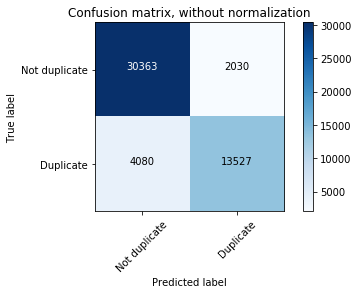

In [230]:

def plot_confusion_matrix(cm, classes,

                          normalize=False,

                          title='Confusion matrix',

                          cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')



    print(cm)



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()

    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    fmt = '.2f' if normalize else 'd'

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, format(cm[i, j], fmt),

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")



    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')



# Compute confusion matrix

y_test = y_test

y_pred = predictions_test_bool



cnf_matrix = confusion_matrix(y_test, y_pred)



np.set_printoptions(precision=2)



# Plot non-normalized confusion matrix

plt.figure()

plot_confusion_matrix(cnf_matrix, classes=['Not duplicate','Duplicate'],

                      title='Confusion matrix, without normalization')

Accuracy:  0.8778
Recall:  0.7682739819390015
Precision:  0.8695121167320178
F1 score:  0.8157640815341938
ROC AUC score:  0.8528030607994023
Average precision-recall score: 0.92


Text(0.5,1,'2-class Precision-Recall curve: AP=0.92')

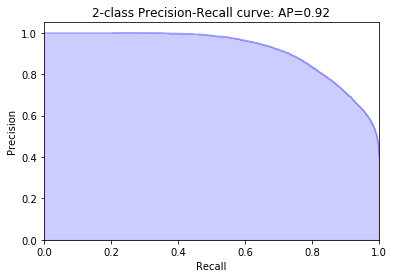

In [231]:
y_test = y_test

y_pred = predictions_test_bool

y_pred_prob = predictions_test[:,1]



rec = recall_score(y_test, y_pred)

prec = precision_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)



print("Accuracy: ", acc)

print("Recall: ", rec)

print("Precision: ", prec)

print("F1 score: ", f1)

print("ROC AUC score: ", roc_auc)






average_precision = average_precision_score(y_test, predTest)



print('Average precision-recall score: {0:0.2f}'.format(

      average_precision))






precision, recall, _ = precision_recall_curve(y_test, predTest)



plt.step(recall, precision, color='b', alpha=0.2,

         where='post')

plt.fill_between(recall, precision, step='post', alpha=0.2,

                 color='b')



plt.xlabel('Recall')

plt.ylabel('Precision')

plt.ylim([0.0, 1.05])

plt.xlim([0.0, 1.0])

plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))